# ***Import Necessary Libraries***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, InceptionResNetV2, EfficientNetB5
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image, ImageFilter

In [ ]:
image = PIL.Image.open("/content/drive/MyDrive/COM726/test/adenocarcinoma/000177.png")


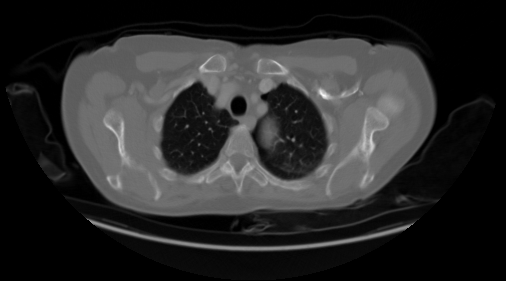

In [ ]:
image

**LOAD DATA FROM DIRECTORY**

**EDA/PreProcessing on Lung cancer images**

In [ ]:
# Directories
data_dir = "/content/drive/MyDrive/COM726/"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")
test_dir= os.path.join(data_dir, "test")

In [ ]:
# Image Data Generators with Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 613 images belonging to 4 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 72 images belonging to 4 classes.


In [ ]:
# Initialize ImageDataGenerator for the test set with only rescaling
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/COM726/test',  # Path to the test data directory
    target_size=(224, 224),  # Resize all images to 224x224 pixels
    batch_size=32,  # Number of images to return in each batch
    class_mode='categorical',  # Return one-hot encoded labels
    shuffle=False  # Do not shuffle the data, to preserve order for evaluation
)

Found 315 images belonging to 4 classes.


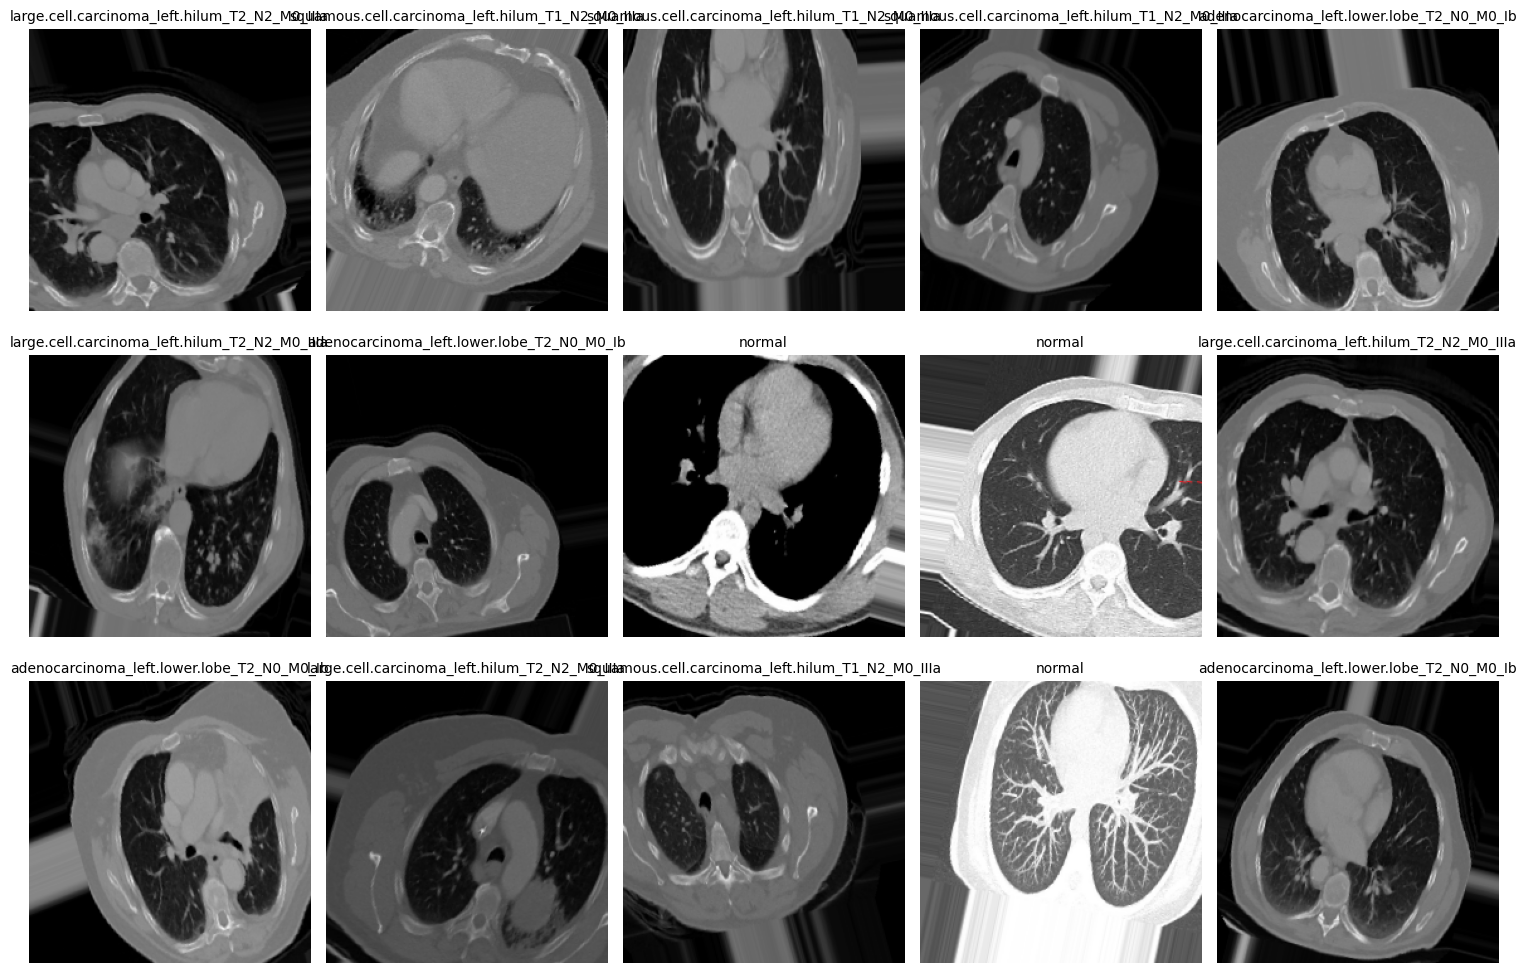

In [ ]:
# Get class names from the train_generator
class_names = list(train_generator.class_indices.keys())

# Plot the first 15 images from the train_generator
plt.figure(figsize=(15, 10))  # Increased figure size

for i, (images, labels) in enumerate(train_generator):
    if i == 15:  # Display only the first 15 images
        break
    plt.subplot(3, 5, i + 1)

    # Convert the image back to the range [0, 255] for display
    img = images[0] * 255
    img = img.astype("uint8")

    plt.imshow(img)
    class_index = labels[0].argmax()  # Get the index of the highest probability class
    class_name = class_names[class_index]
    plt.title(class_name, fontsize=10)  # Adjust font size for better readability
    plt.axis("off")

# Adjust the spacing between plots to prevent overlap
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.tight_layout()
plt.show()

**LOAD DATA FROM DIRECTORY**

**EDA/PreProcessing on Lung cancer images**

>



In [ ]:
#To check and remove when junk folder ipynb is created
import shutil
import os

folder_path = '/content/drive/MyDrive/COM726/train/.ipynb_checkpoints'

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print("Folder deleted successfully.")
else:
    print("Folder not found.")

Folder not found.


In [ ]:
#Number of images in each class
ROOT_DIR="/content/drive/MyDrive/COM726"
number_of_images = {}


# Iterate over the train, valid, and test directories
for subset in ["train", "valid", "test"]:
    subset_dir = os.path.join(ROOT_DIR, subset)
    number_of_images[subset] = {}

    # Iterate over each class directory within the subset directory
    for class_dir in os.listdir(subset_dir):
        class_path = os.path.join(subset_dir, class_dir)
        if os.path.isdir(class_path):  # Check if it's a directory
            number_of_images[subset][class_dir] = len(os.listdir(class_path))

# Print the counts
for subset, classes in number_of_images.items():
    print(f"{subset.capitalize()} data:")
    for class_name, count in classes.items():
        print(f"  {class_name}: {count} images")

Train data:
  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 195 images
  large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 115 images
  normal: 148 images
  squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 155 images
Valid data:
  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 23 images
  large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 21 images
  normal: 13 images
  squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 15 images
Test data:
  adenocarcinoma: 120 images
  large.cell.carcinoma: 51 images
  normal: 54 images
  squamous.cell.carcinoma: 90 images


**Pre processing**

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Verify the mount
!ls /content/drive/MyDrive/COM726/train

# Step 3: Define the preprocessing function
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib     normal
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa  squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


In [ ]:
# Model Creation Function with Dropout and L2 Regularization
def create_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization
    x = Dropout(0.5)(x)  # Dropout layer
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
# Compile and Train Function with Early Stopping and ReduceLROnPlateau
def compile_and_train(model, epochs=50):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr]
    )
    return history


In [ ]:
# Plot Accuracy and Loss Function
def plot_accuracy_loss(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.show()

In [ ]:
# Plot Confusion Matrix Function
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices, yticklabels=train_generator.class_indices)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
# Plot ROC Curve Function
def plot_roc_curve(y_true, y_pred_proba, model_name):
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(train_generator.class_indices):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'{model_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
# Prepare the ground truth labels and predictions
def prepare_labels_preds(model):
    val_generator.reset()
    y_true = []
    y_pred = []
    y_pred_proba = []
    for i in range(len(val_generator)):
        X, y = val_generator[i]
        y_true.extend(np.argmax(y, axis=1))
        preds = model.predict(X)
        y_pred.extend(np.argmax(preds, axis=1))
        y_pred_proba.extend(preds)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_proba = np.array(y_pred_proba)
    return y_true, y_pred, y_pred_proba

# Training and Evaluating Models

In [ ]:
# VGG16
base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_vgg16 = create_model(base_vgg16)
history_vgg16 = compile_and_train(model_vgg16, epochs=50)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 187s 7s/step - accuracy: 0.2655 - loss: 3.1734 - val_accuracy: 0.4583 - val_loss: 1.7341 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 519ms/step - accuracy: 0.3229 - loss: 1.6795 - val_accuracy: 0.3194 - val_loss: 1.5230 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 509ms/step - accuracy: 0.3850 - loss: 1.4713 - val_accuracy: 0.2083 - val_loss: 1.4127 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 505ms/step - accuracy: 0.3718 - loss: 1.5409 - val_accuracy: 0.4722 - val_loss: 1.2162 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 504ms/step - accuracy: 0.4820 - loss: 1.2448 - val_accuracy: 0.1806 - val_loss: 1.7614 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 513ms/step - accuracy: 0.3899 - loss: 1.3893 - val_accuracy: 0.3056 - val_loss: 1.2719 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 544ms/step - accuracy: 0.4844 - loss: 1.1866 - val_ac

In [ ]:
# Saving the VGG16 Model
model_vgg16.save('/content/drive/MyDrive/COM726/VGG16_model.keras')

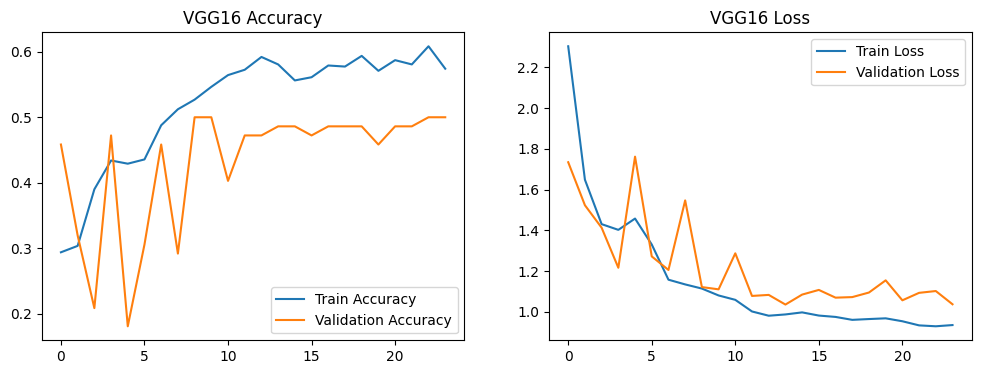

In [ ]:
# VGG16 Plot
plot_accuracy_loss(history_vgg16, 'VGG16')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


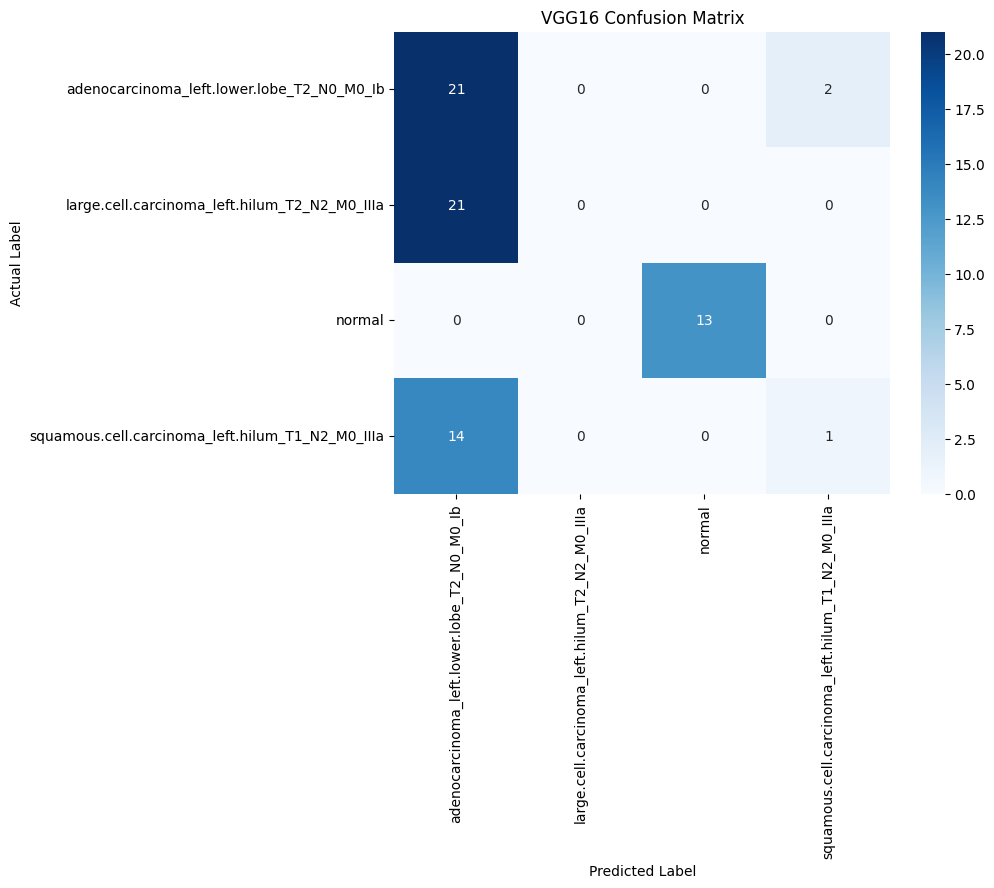

In [ ]:
# VGG16 Confusion Matrix
y_true, y_pred, y_pred_proba = prepare_labels_preds(model_vgg16)
plot_confusion_matrix(y_true, y_pred, 'VGG16')

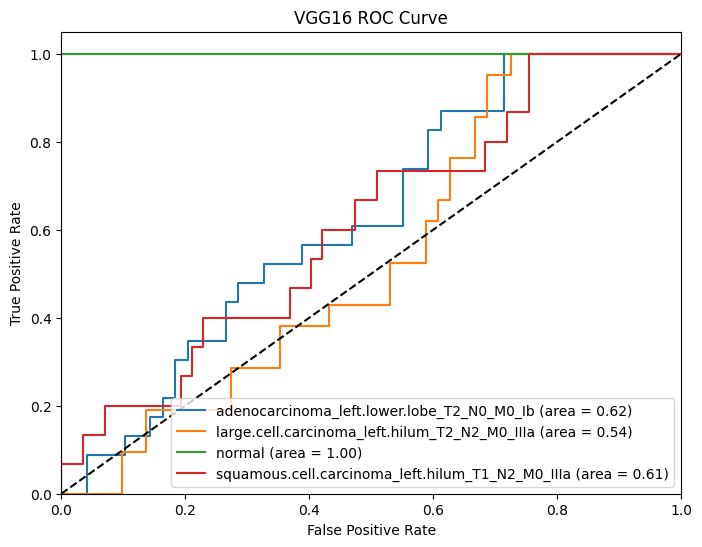

In [ ]:
# VGG16 ROC
plot_roc_curve(tf.keras.utils.to_categorical(y_true), y_pred_proba, 'VGG16')

In [ ]:
# ResNet101
base_resnet101 = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet101 = create_model(base_resnet101)
history_resnet101 = compile_and_train(model_resnet101, epochs=50)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 182s 4s/step - accuracy: 0.4208 - loss: 3.1556 - val_accuracy: 0.1806 - val_loss: 118949688.0000 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 586ms/step - accuracy: 0.6003 - loss: 2.1811 - val_accuracy: 0.1806 - val_loss: 142119648.0000 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 574ms/step - accuracy: 0.5995 - loss: 2.0937 - val_accuracy: 0.1806 - val_loss: 5823024.0000 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 559ms/step - accuracy: 0.6926 - loss: 1.8822 - val_accuracy: 0.1806 - val_loss: 74662.1016 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 586ms/step - accuracy: 0.6663 - loss: 1.8166 - val_accuracy: 0.1806 - val_loss: 8.8980 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 585ms/step - accuracy: 0.6845 - loss: 1.5786 - val_accuracy: 0.1806 - val_loss: 666.5164 - learning_rate: 0.0010
Epo

In [ ]:
# Saving the ResNet101 Model
model_resnet101.save('/content/drive/MyDrive/COM726/ResNet101_1_model.keras')

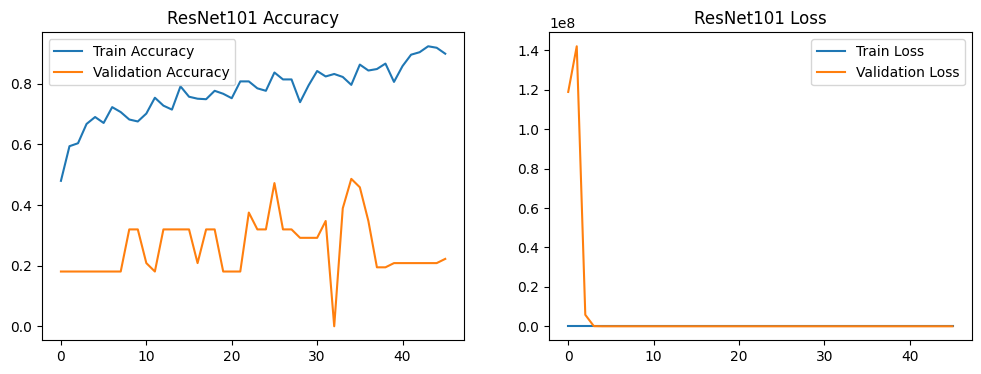

In [ ]:
# ResNet101 Plot
plot_accuracy_loss(history_resnet101, 'ResNet101')

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


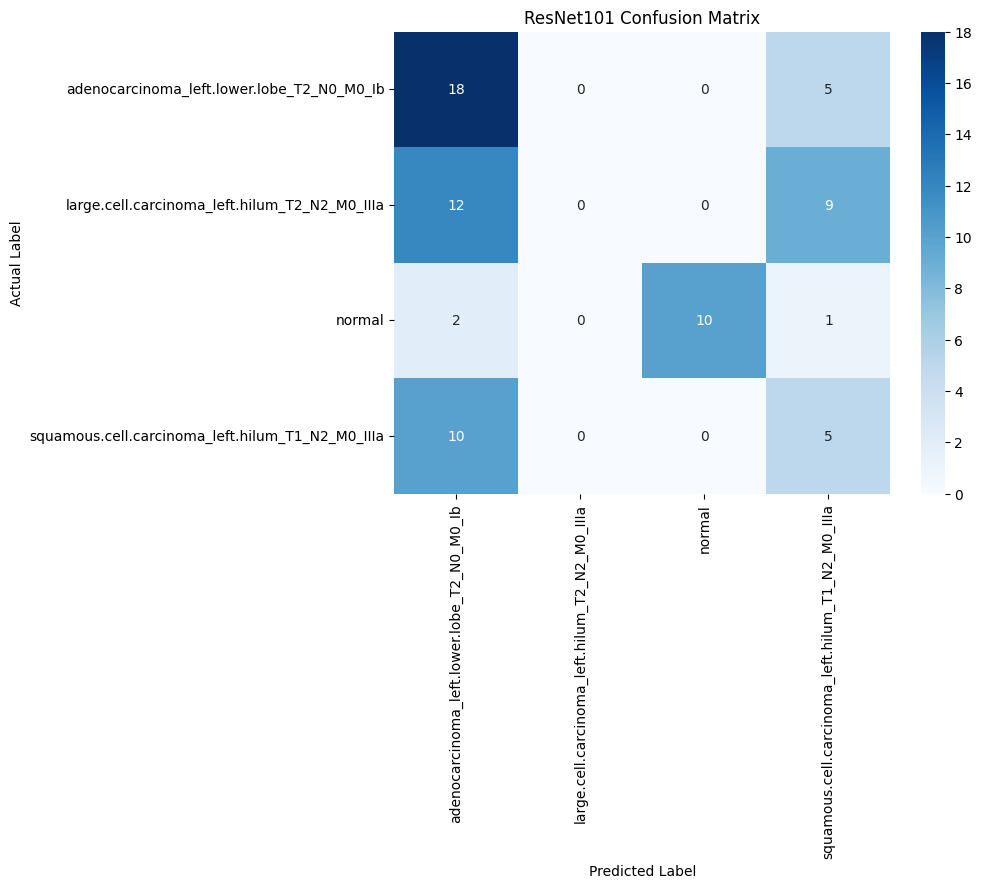

In [ ]:
# ResNet101 Confusion Matrix
y_true, y_pred, y_pred_proba = prepare_labels_preds(model_resnet101)
plot_confusion_matrix(y_true, y_pred, 'ResNet101')

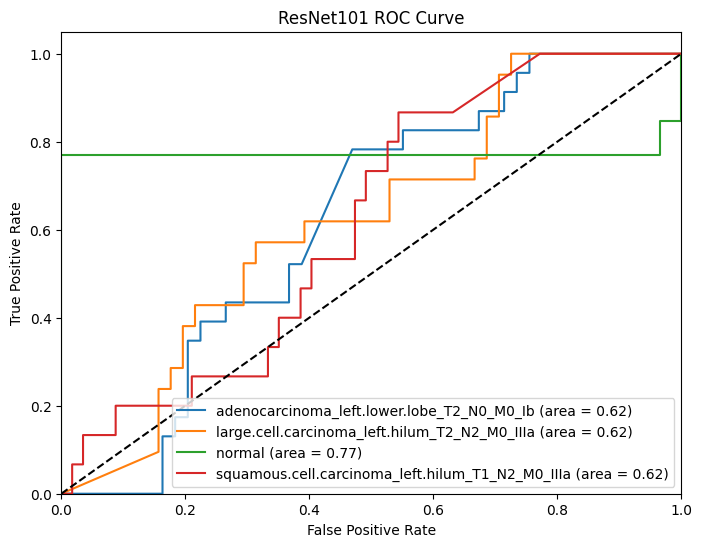

In [ ]:
# ResNet101 ROC
plot_roc_curve(tf.keras.utils.to_categorical(y_true), y_pred_proba, 'ResNet101')

**#2 InceptionResNetV2**

In [ ]:
# InceptionResNetV2
base_inceptionresnetv2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_inceptionresnetv2 = create_model(base_inceptionresnetv2)
history_inceptionresnetv2 = compile_and_train(model_inceptionresnetv2, epochs=50)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 258s 5s/step - accuracy: 0.4571 - loss: 2.5954 - val_accuracy: 0.1944 - val_loss: 8.4752 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 526ms/step - accuracy: 0.6619 - loss: 1.9013 - val_accuracy: 0.3056 - val_loss: 57.2877 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 544ms/step - accuracy: 0.6354 - loss: 2.0363 - val_accuracy: 0.2778 - val_loss: 15715.7861 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 538ms/step - accuracy: 0.7493 - loss: 1.5301 - val_accuracy: 0.3194 - val_loss: 2013.8533 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 553ms/step - accuracy: 0.6320 - loss: 1.6401 - val_accuracy: 0.4306 - val_loss: 42.9398 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 551ms/step - accuracy: 0.8085 - loss: 1.1910 - val_accuracy: 0.1944 - val_loss: 8.0091 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━

In [ ]:
# Saving the InceptionResNetV2 Model
model_inceptionresnetv2.save('/content/drive/MyDrive/InceptionResNetV2_model.keras')

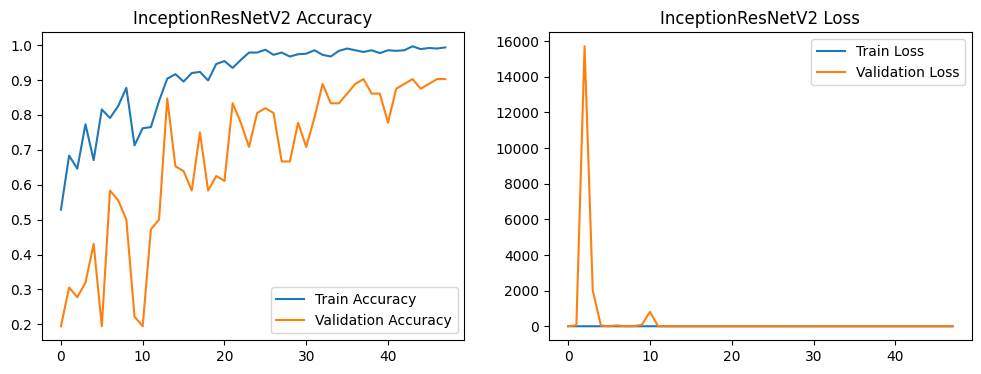

In [ ]:
# InceptionResNetV2 Plot
plot_accuracy_loss(history_inceptionresnetv2, 'InceptionResNetV2')

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


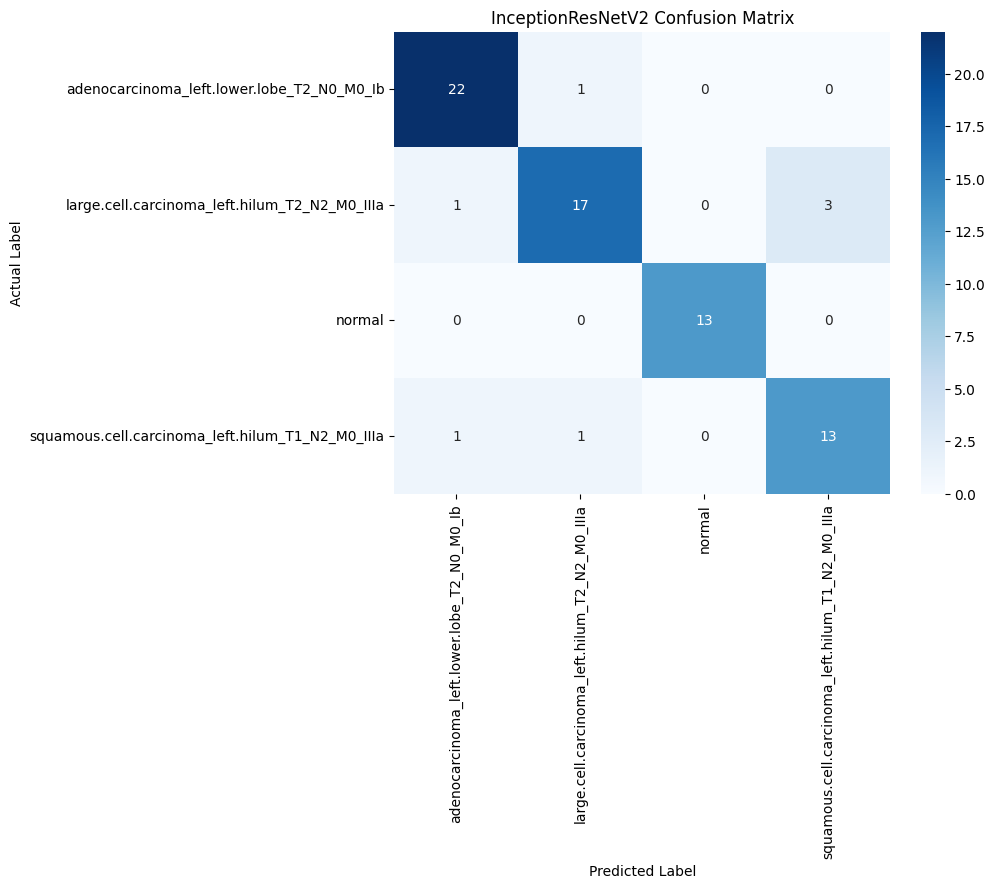

In [ ]:
# InceptionResNetV2 Confusion Matrix
y_true, y_pred, y_pred_proba = prepare_labels_preds(model_inceptionresnetv2)
plot_confusion_matrix(y_true, y_pred, 'InceptionResNetV2')

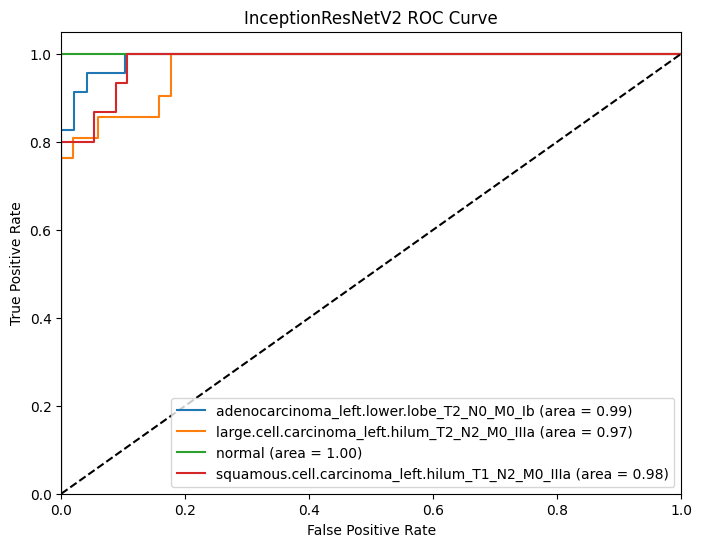

In [ ]:
# InceptionResNetV2 ROC
plot_roc_curve(tf.keras.utils.to_categorical(y_true), y_pred_proba, 'InceptionResNetV2')

In [ ]:
# EfficientNetB5
base_efficientnetb5 = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_efficientnetb5 = create_model(base_efficientnetb5)
history_efficientnetb5 = compile_and_train(model_efficientnetb5, epochs=50)

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 311s 7s/step - accuracy: 0.4943 - loss: 2.4705 - val_accuracy: 0.2083 - val_loss: 3.4405 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 591ms/step - accuracy: 0.7074 - loss: 1.9793 - val_accuracy: 0.3194 - val_loss: 2.7641 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 550ms/step - accuracy: 0.8204 - loss: 1.7428 - val_accuracy: 0.3194 - val_loss: 3.3866 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 520ms/step - accuracy: 0.8041 - loss: 1.6021 - val_accuracy: 0.2917 - val_loss: 4.4966 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 534ms/step - accuracy: 0.8457 - loss: 1.3666 - val_accuracy: 0.2083 - val_loss: 3.2822 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 554ms/step - accuracy: 0.8923 - loss: 1.1716 - val_accuracy: 0.2083 - val_loss: 2.7409 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━

In [ ]:
# Saving the EfficientnetB5 Model
model_efficientnetb5.save('/content/drive/MyDrive/EfficientNetB5_model.keras')

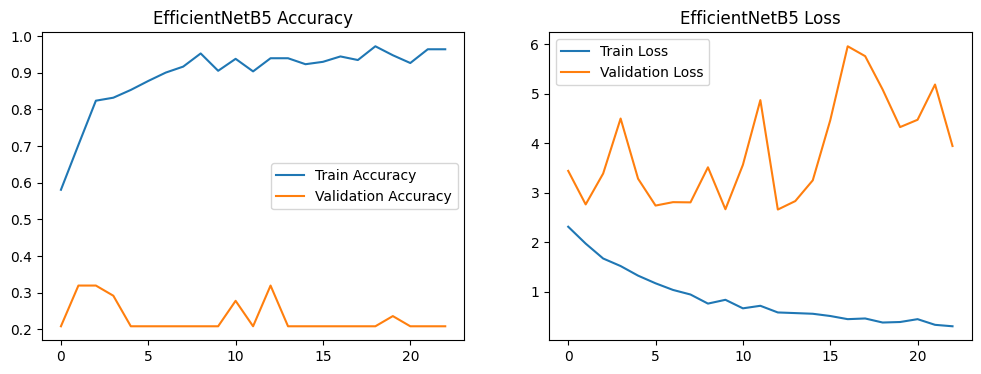

In [ ]:
# EfficientnetB5 Plot
plot_accuracy_loss(history_efficientnetb5, 'EfficientNetB5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


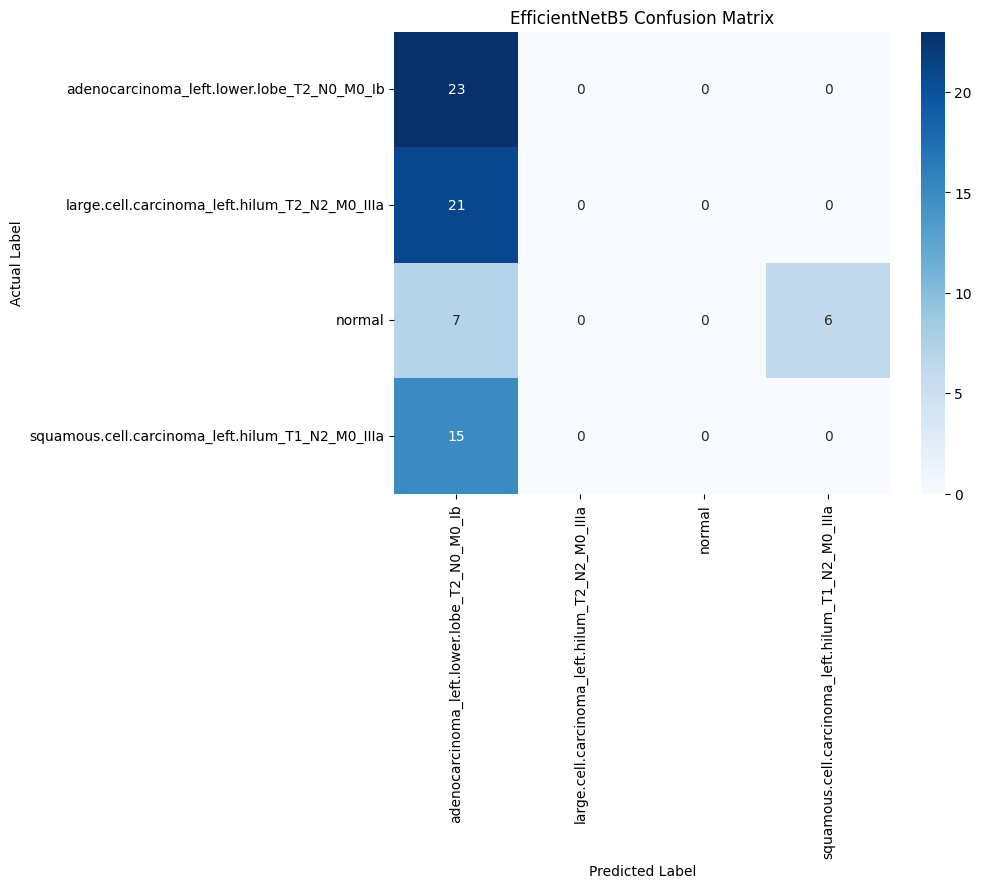

In [ ]:
# EfficientnetB5 Confusion Matrix
y_true, y_pred, y_pred_proba = prepare_labels_preds(model_efficientnetb5)
plot_confusion_matrix(y_true, y_pred, 'EfficientNetB5')

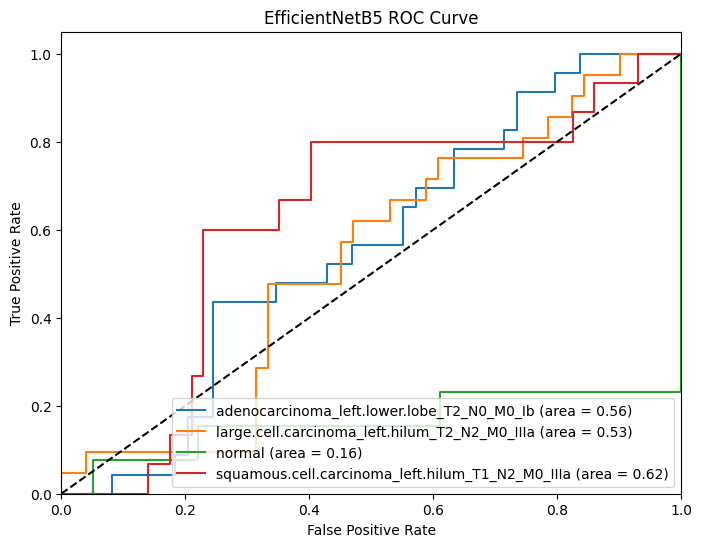

In [ ]:
# EfficientnetB5 ROC
plot_roc_curve(tf.keras.utils.to_categorical(y_true), y_pred_proba, 'EfficientNetB5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved models
vgg16_model = load_model('/content/drive/MyDrive/VGG16_model.keras')
resnet101_model = load_model('/content/drive/MyDrive/ResNet101_model.keras')
inceptionresnetv2_model = load_model('/content/drive/MyDrive/InceptionResNetV2_model.keras')
efficientnetb5_model = load_model('/content/drive/MyDrive/EfficientNetB5_model.keras')


In [ ]:
# Evaluate models on the validation data
vgg16_eval = vgg16_model.evaluate(val_generator, verbose=0)
resnet101_eval = resnet101_model.evaluate(val_generator, verbose=0)
inceptionresnetv2_eval = inceptionresnetv2_model.evaluate(val_generator, verbose=0)
efficientnetb5_eval = efficientnetb5_model.evaluate(val_generator, verbose=0)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame to compare the models
comparison_df = pd.DataFrame({
    'Model': ['VGG16', 'ResNet101', 'InceptionResNetV2', 'EfficientNetB5'],
    'Train Accuracy': [
        max(history_vgg16.history['accuracy']),
        max(history_resnet101.history['accuracy']),
        max(history_inceptionresnetv2.history['accuracy']),
        max(history_efficientnetb5.history['accuracy']),
    ],
    'Validation Accuracy': [
        vgg16_eval[1],  # validation accuracy
        resnet101_eval[1],  # validation accuracy
        inceptionresnetv2_eval[1],  # validation accuracy
        efficientnetb5_eval[1],  # validation accuracy
    ],
    'Train Loss': [
        min(history_vgg16.history['loss']),
        min(history_resnet101.history['loss']),
        min(history_inceptionresnetv2.history['loss']),
        min(history_efficientnetb5.history['loss']),
    ],
    'Validation Loss': [
        vgg16_eval[0],  # validation loss
        resnet101_eval[0],  # validation loss
        inceptionresnetv2_eval[0],  # validation loss
        efficientnetb5_eval[0],  # validation loss
    ]
})

# Display the comparison table
print(comparison_df)

               Model  Train Accuracy  Validation Accuracy  Train Loss  \
0              VGG16        0.608483             0.486111    0.928966   
1          ResNet101        0.923328             0.291667    0.319474   
2  InceptionResNetV2        0.996737             0.902778    0.201836   
3     EfficientNetB5        0.972268             0.291667    0.305783   

   Validation Loss  
0         1.087819  
1         1.539689  
2         0.631423  
3       120.029503  


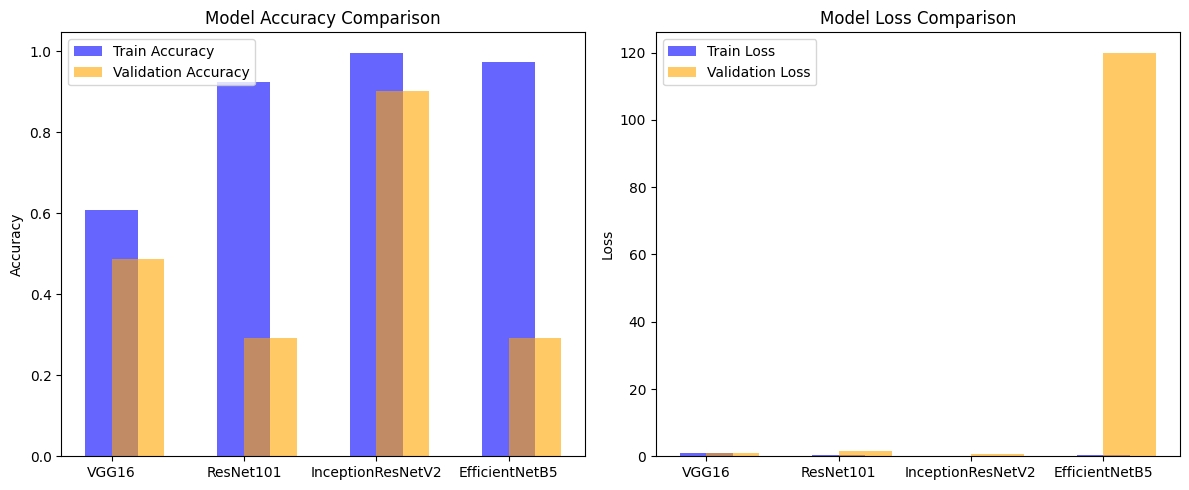

               Model  Train Accuracy  Validation Accuracy  Train Loss  \
0              VGG16        0.608483             0.486111    0.928966   
1          ResNet101        0.923328             0.291667    0.319474   
2  InceptionResNetV2        0.996737             0.902778    0.201836   
3     EfficientNetB5        0.972268             0.291667    0.305783   

   Validation Loss  
0         1.087819  
1         1.539689  
2         0.631423  
3       120.029503  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame to compare the models
comparison_df = pd.DataFrame({
    'Model': ['VGG16', 'ResNet101', 'InceptionResNetV2', 'EfficientNetB5'],
    'Train Accuracy': [
        max(history_vgg16.history['accuracy']),
        max(history_resnet101.history['accuracy']),
        max(history_inceptionresnetv2.history['accuracy']),
        max(history_efficientnetb5.history['accuracy']),
    ],
    'Validation Accuracy': [
        vgg16_eval[1],  # validation accuracy
        resnet101_eval[1],  # validation accuracy
        inceptionresnetv2_eval[1],  # validation accuracy
        efficientnetb5_eval[1],  # validation accuracy
    ],
    'Train Loss': [
        min(history_vgg16.history['loss']),
        min(history_resnet101.history['loss']),
        min(history_inceptionresnetv2.history['loss']),
        min(history_efficientnetb5.history['loss']),
    ],
    'Validation Loss': [
        vgg16_eval[0],  # validation loss
        resnet101_eval[0],  # validation loss
        inceptionresnetv2_eval[0],  # validation loss
        efficientnetb5_eval[0],  # validation loss
    ]
})

# Plotting Train vs Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(comparison_df['Model'], comparison_df['Train Accuracy'], width=0.4, label='Train Accuracy', align='center', alpha=0.6, color='blue')
plt.bar(comparison_df['Model'], comparison_df['Validation Accuracy'], width=0.4, label='Validation Accuracy', align='edge', alpha=0.6, color='orange')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()

# Plotting Train vs Validation Loss
plt.subplot(1, 2, 2)
plt.bar(comparison_df['Model'], comparison_df['Train Loss'], width=0.4, label='Train Loss', align='center', alpha=0.6, color='blue')
plt.bar(comparison_df['Model'], comparison_df['Validation Loss'], width=0.4, label='Validation Loss', align='edge', alpha=0.6, color='orange')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')
plt.legend()

plt.tight_layout()
plt.show()

# Display the comparison table
print(comparison_df)

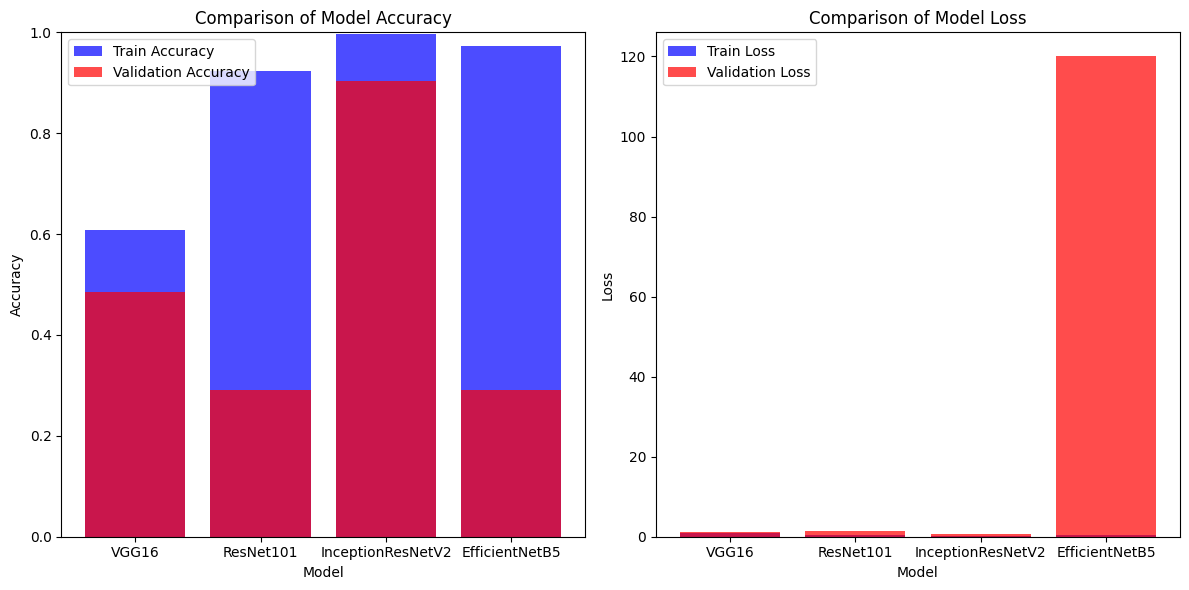

In [ ]:
# Plotting the bar charts for Accuracy and Validation Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(comparison_df['Model'], comparison_df['Train Accuracy'], color='blue', alpha=0.7, label='Train Accuracy')
plt.bar(comparison_df['Model'], comparison_df['Validation Accuracy'], color='red', alpha=0.7, label='Validation Accuracy')
plt.title('Comparison of Model Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(comparison_df['Model'], comparison_df['Train Loss'], color='blue', alpha=0.7, label='Train Loss')
plt.bar(comparison_df['Model'], comparison_df['Validation Loss'], color='red', alpha=0.7, label='Validation Loss')
plt.title('Comparison of Model Loss')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Testing the model with the best one

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

# Load the pre-trained InceptionResNetV2 model from the .keras file
model = load_model('/content/drive/MyDrive/InceptionResNetV2_model.keras')

# Prepare your test data using ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/COM726/test',  # Directory for test data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predict on the test data
predictions = model.predict(test_generator, verbose=1)

# Convert predictions from probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels
true_classes = test_generator.classes

# Calculate the test accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Predict and display the type of lung cancer for each image
class_labels = list(test_generator.class_indices.keys())
for i, pred in enumerate(predicted_classes):
    print(f'Image {i+1}: Predicted Cancer Type - {class_labels[pred]}')


Found 315 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 146s 15s/step
Test Accuracy: 93.65%
Image 1: Predicted Cancer Type - adenocarcinoma
Image 2: Predicted Cancer Type - adenocarcinoma
Image 3: Predicted Cancer Type - adenocarcinoma
Image 4: Predicted Cancer Type - adenocarcinoma
Image 5: Predicted Cancer Type - adenocarcinoma
Image 6: Predicted Cancer Type - squamous.cell.carcinoma
Image 7: Predicted Cancer Type - adenocarcinoma
Image 8: Predicted Cancer Type - adenocarcinoma
Image 9: Predicted Cancer Type - large.cell.carcinoma
Image 10: Predicted Cancer Type - adenocarcinoma
Image 11: Predicted Cancer Type - adenocarcinoma
Image 12: Predicted Cancer Type - adenocarcinoma
Image 13: Predicted Cancer Type - adenocarcinoma
Image 14: Predicted Cancer Type - adenocarcinoma
Image 15: Predicted Cancer Type - adenocarcinoma
Image 16: Predicted Cancer Type - adenocarcinoma
Image 17: Predicted Cancer Type - adenocarcinoma
Image 18: Predicted Cancer Type - adenocarcinoma
Image 19: Predicted Cancer Type - adenocarcinoma


Found 315 images belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


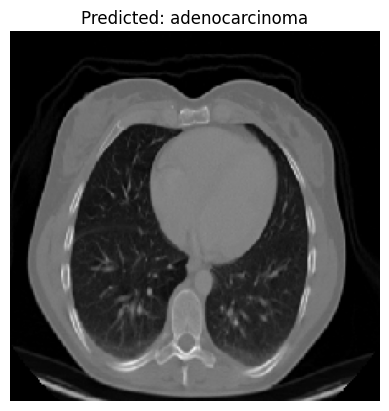

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


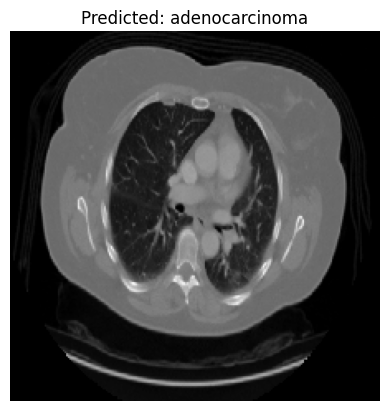

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


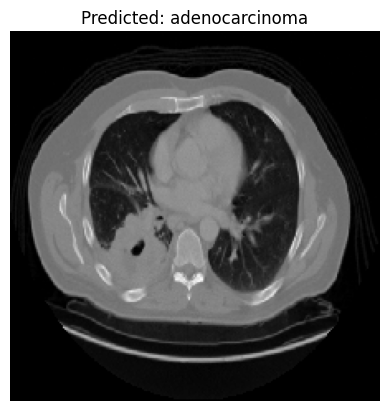

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


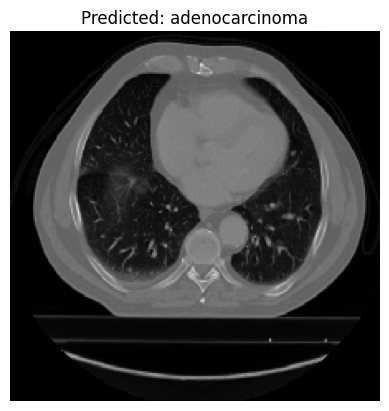

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


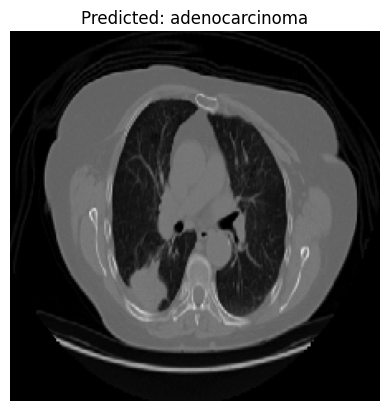

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


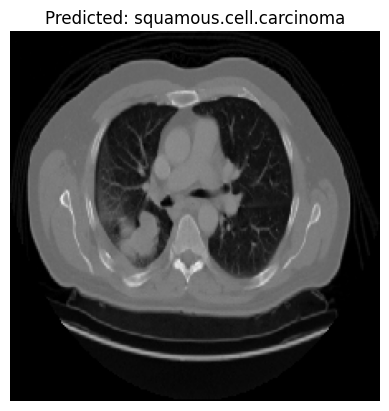

True label: adenocarcinoma
Predicted label: squamous.cell.carcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


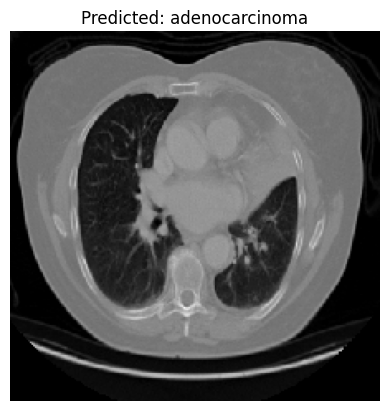

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


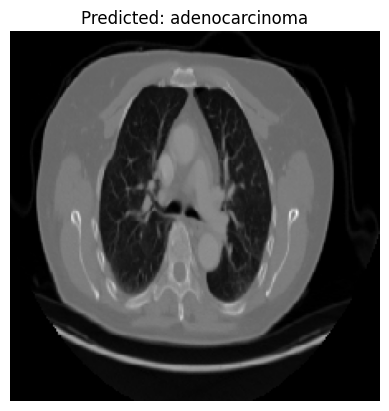

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


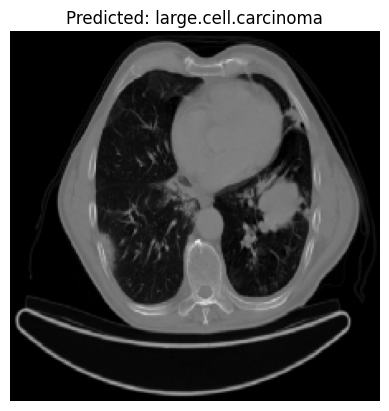

True label: adenocarcinoma
Predicted label: large.cell.carcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


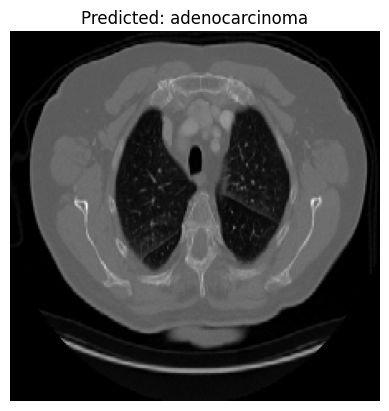

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


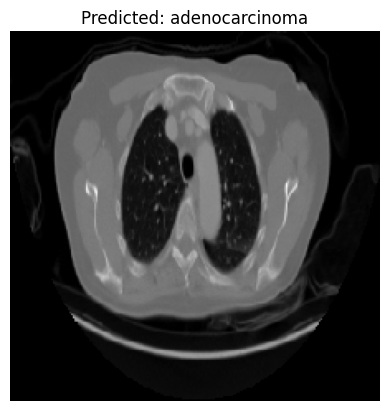

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


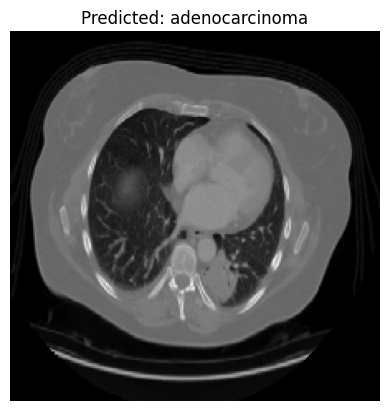

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


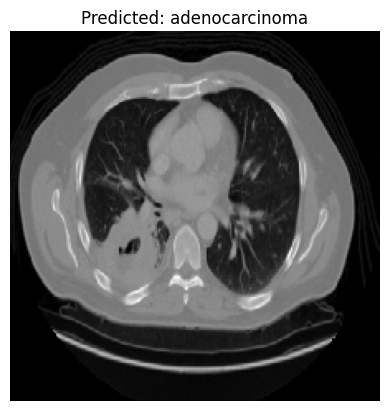

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


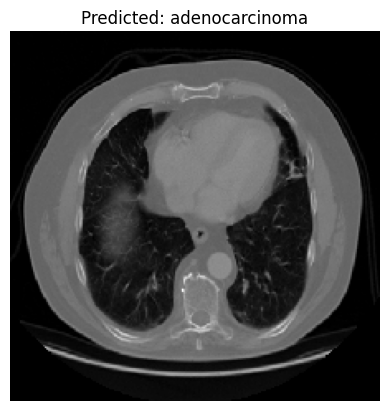

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


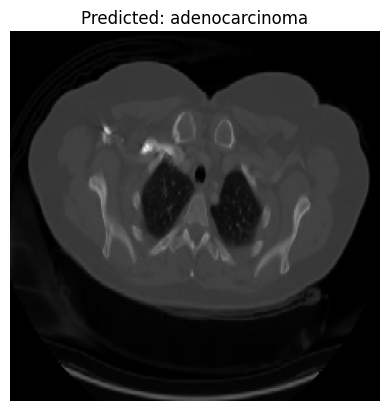

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


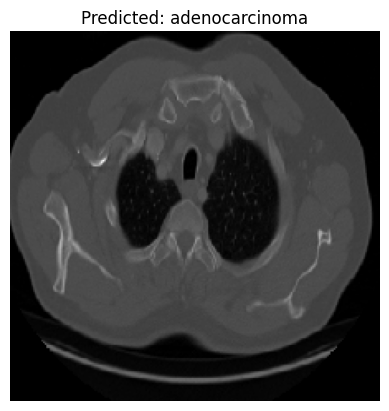

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


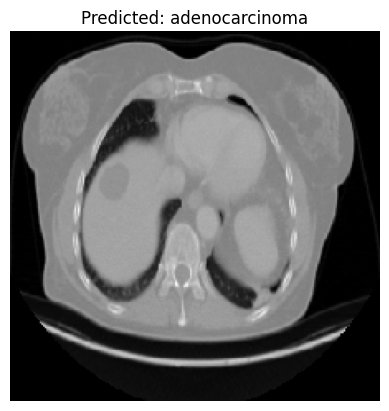

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


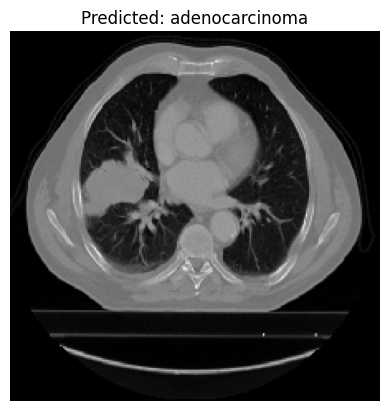

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


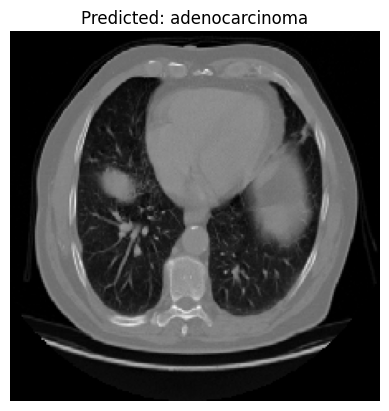

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


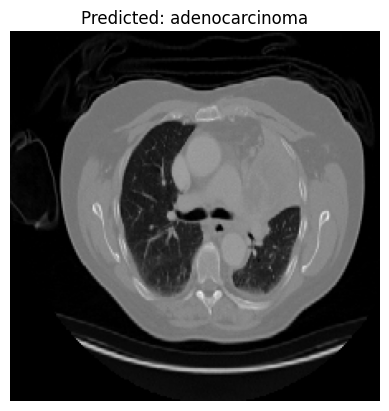

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


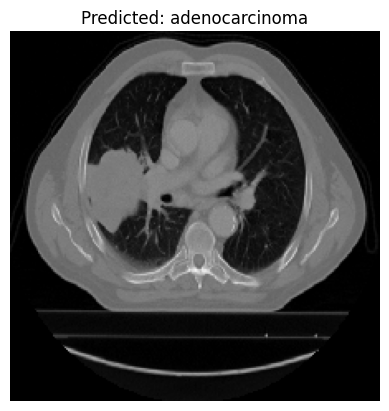

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


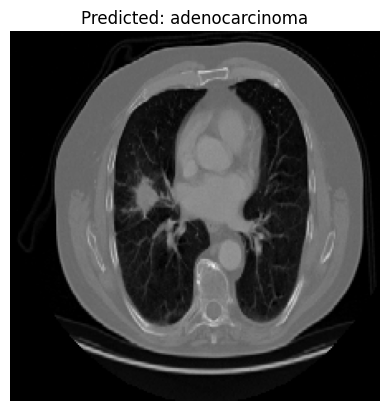

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


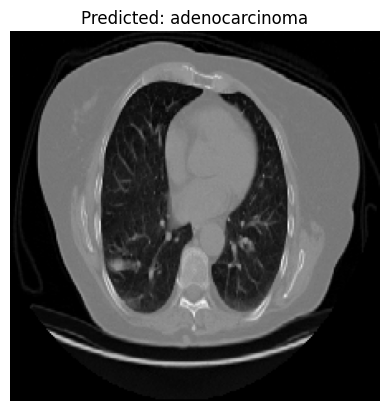

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


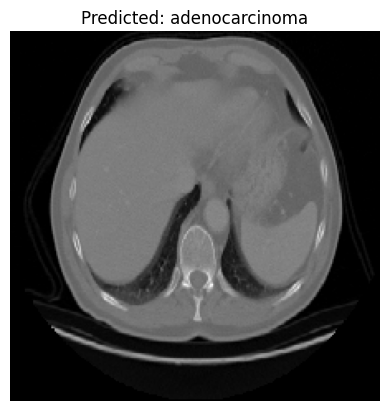

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


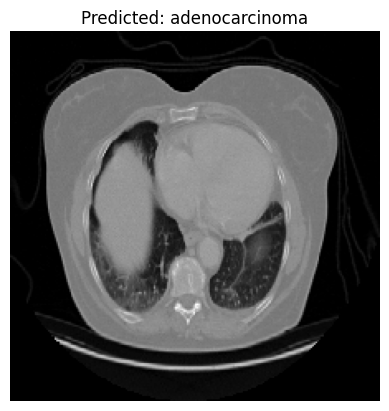

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


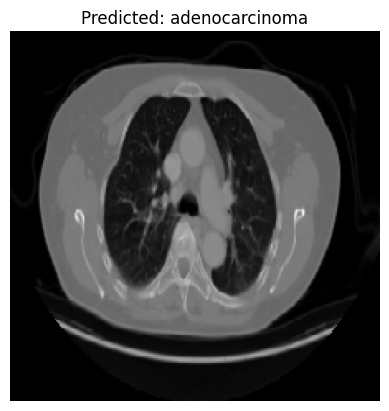

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


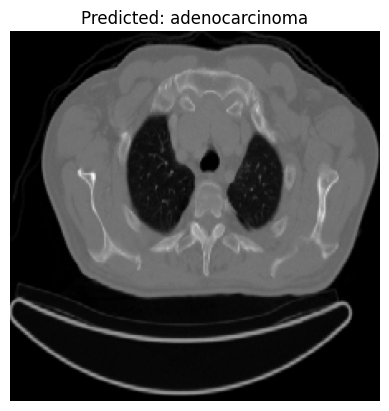

True label: adenocarcinoma
Predicted label: adenocarcinoma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


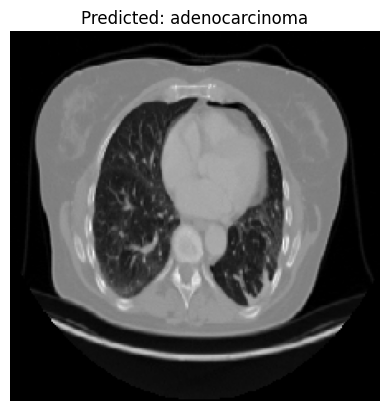

True label: adenocarcinoma
Predicted label: adenocarcinoma



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained InceptionResNetV2 model from the .keras file
model = load_model('/content/drive/MyDrive/InceptionResNetV2_model.keras')

# Prepare the test data generator (note: images are not shuffled for consistent display)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/COM726/test',  # Directory for test data
    target_size=(224, 224),
    batch_size=1,  # Load one image at a time
    class_mode='categorical',
    shuffle=False
)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Iterate over each image in the test set
for i in range(len(test_generator)):
    # Load a single image and its true label
    img, label = next(test_generator)

    # Predict the class of the image
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Display the image
    plt.imshow(img[0])
    plt.axis('off')
    plt.title(f'Predicted: {class_labels[predicted_class]}')
    plt.show()

    # Print out the true and predicted labels
    true_class = np.argmax(label, axis=1)[0]
    print(f'True label: {class_labels[true_class]}')
    print(f'Predicted label: {class_labels[predicted_class]}\n')


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
# Print the test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

In [ ]:
!pip install shap

#XAI

In [ ]:
from tensorflow.keras.models import load_model

# Load the InceptionResNetV2 model
model = load_model('/content/drive/MyDrive/InceptionResNetV2_model.keras')

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Load a batch of images and their labels from the test generator
X_batch, y_batch = next(test_generator)  # X_batch is a NumPy array now

# Initialize a SHAP explainer for the model
explainer = shap.DeepExplainer(model, X_batch)

# Select a single image for explanation
X = X_batch[:1]  # Select the first image in the batch

# Generate SHAP values for the selected image
shap_values = explainer.shap_values(X)

# Normalize SHAP values to range [0, 1]
shap_values_normalized = [np.clip(val, 0, 1) for val in shap_values]

# Plot SHAP values for the first image in the batch
shap.image_plot(shap_values_normalized, X)


In [ ]:
!pip install lime

#LIME

In [ ]:
# LIME - to explain individual predictions from the model
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load the test data
X, y = next(test_generator)  # This loads a batch of images and their corresponding labels from the test set

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain an image from the test set using LIME
# Here X[0] refers to the first image in the batch
explanation = explainer.explain_instance(X[0], model.predict, top_labels=1, hide_color=0, num_samples=1000)

# Display the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.show()